# Test notebook
for porting collective radiance code to python

In [1]:
from numpy import *
import numpy.linalg as la
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from time import time
from random import random
import csv

# local 
from physconsts import *
from simfuncs import *

### two level Rabi oscillation example

In [2]:
## simple Rabi oscillation in two level atom

psi0 = array([1,0], complex) # population starts in |g>

delta = 10
omega = 2*pi

# atom+field Hamiltonian, hbar=1
Haf = array([[0,-omega/2],[-omega/2,0]])

numsteps = 100
tmin = 0
tmax = 3 
tpts = linspace(tmin,tmax,numsteps)

dpsi = lambda t,state: 1j*dot(Haf,state)

soln = solve_ivp(dpsi,[tmin,tmax],psi0, t_eval=tpts,vectorized=True)

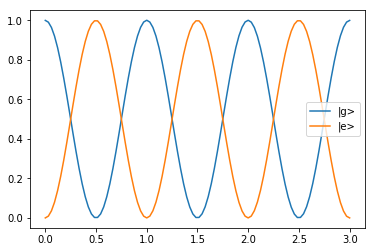

In [3]:
labels = ['|g>','|e>']
for i,y in enumerate(soln.y):
    plt.plot(soln.t,real(conjugate(y)*y),label=labels[i])
plt.legend(loc='best')

## reproduce single-excitation collective radiance results from my Mathematica code

In [5]:
# constants setup
lmbda = 7.8e-7
k = 2*pi/lmbda

# function definitions
unit = lambda v: array(v)/sqrt(dot(array(v),array(v)))
egen = eye(3) # generic basis set
ecart = [array([1,0,-1])/sqrt(2), 
         -1j*array([1,0,1])/sqrt(2), 
         array([0,1,0])]
# matelem = ee*a0
# gamma = matelem**2*k**3/(6*pi*e0)
gamma = 1

r = lambda i,j: array([0, 
                       mod(j,sqrt(atomnum)) - mod(i,sqrt(atomnum)),
                       floor(j/sqrt(atomnum)) - floor(i/sqrt(atomnum))])

def gdotp(r,p):
    """
    Dipole radiation measured at r
    Args:
        r: distance from dipole to measurement location
        p: vector representation of source dipole
    Returns:
        y: G acting on p, a complex vector
    """
    y = exp(1j*k*sqrt(dot(r,r)))*(cross(cross(unit(r),p),unit(r))
                                   + (1/(dot(r,r)*k**2)  
                                   - 1j/(k*sqrt(dot(r,r)))) \
                                   *(3*unit(r)*dot(unit(r),p) - p)) \
                                 /(4*pi*sqrt(dot(r,r)))
    return y

class ArrayMode:
    
    def __init__(self, vector, name, color):
        self.vector = vector
        self.name = name
        self.color = color
        
    def __repr__(self):
        return f"ArrayMode({self.name})"

### linewidth v period

In [118]:
# square grid setup
atomnum = 25
gridname = "square"
fmode = ArrayMode(unit(full(atomnum,1)), 'Symmetric', 'blue')
afmode = ArrayMode(unit([(-1)**(i+1) for i in range(atomnum)]), 'Asymmetric', 'purple')
modelist = [fmode, afmode]

basisnum = atomnum

In [119]:
# build the hamiltonian

unitp = egen[0] # atom polarization
dsteps = linspace(0.01,1.0,10)
soln = empty((len(modelist),len(dsteps)),float)

t0 = time()
for d_idx,d in enumerate(dsteps):
    hamiltonian = empty((basisnum, basisnum), complex)
    
    # build the hamiltonian

    for i in range(basisnum):
        for j in range(basisnum):
            if i!=j:
                u = lmbda*d*r(i,j)
                hamiltonian[i,j] = 6*pi*gamma*dot(unitp, gdotp(u, unitp))/k
            else:
                hamiltonian[i,j] = 1j*gamma
    
    # find eigenmodes that overlap target mode
    evals,evecs = la.eig(hamiltonian)
    for m_idx,mode in enumerate(modelist):
        overlap = [[] for i in range(basisnum)]
        for i in range(basisnum):
            overlap[i] = [i,abs(dot(mode.vector, evecs[:,i]))]
        overlap.sort(key=lambda x: x[1]) # sort by overlap
        max_idx = overlap[-1][0]
        soln[m_idx,d_idx] = imag(evals[max_idx])/gamma
        
    print(f"calculated step {d_idx}")

print(f"sim ran for {floor((time()-t0)/60)} minutes")

calculated step 0
calculated step 1
calculated step 2
calculated step 3
calculated step 4
calculated step 5
calculated step 6
calculated step 7
calculated step 8
calculated step 9
sim ran for 0.0 minutes


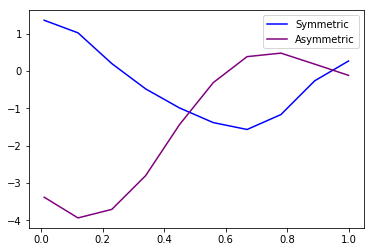

In [120]:
fig,ax = plt.subplots()
for s,m in zip(soln,modelist):
    ax.plot(dsteps,log10(s),label=m.name,c=m.color)
ax.legend()

In [8]:
# test write soln to csv
data = [dsteps] + [s for s in soln]
labels = ['d [lambda]'] + [m.name for m in modelist]

soln_to_csv('testfun1.csv', data, labels)

In [9]:
# test retrieve soln from csv
data, labels = soln_from_csv('testfun1.csv')
xsteps = data[0]
soln = data[1:]

xlabel = labels[0]
ylabels = labels[1:]

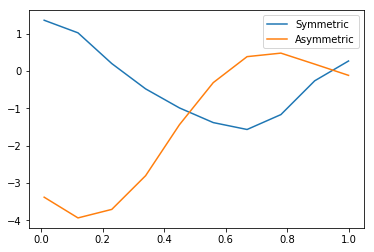

In [122]:
# plot the soln to verify it was stored and retrieved correctly
fig,ax = plt.subplots()
for s,l in zip(soln,ylabels):
    ax.plot(xsteps,log10(s),label=l)
ax.legend()

### time evolution - single excitation states

In [6]:
# square grid setup
atomnum = 25
gridname = "square"
fmode = ArrayMode(unit(full(atomnum,1,complex)), 'Symmetric', 'blue')
afmode = ArrayMode(unit(array([(-1)**(i+1) for i in range(atomnum)],complex)), 'Asymmetric', 'purple')
modelist = [fmode, afmode]
center_idx = int(floor(sqrt(atomnum)/2)*(sqrt(atomnum)+1))

basisnum = atomnum

In [78]:
## params
unitp = egen[0] # atom polarization
d = 0.75
tmin = 0 
tmax = 100
numsteps = 100
tsteps = linspace(tmin, tmax, numsteps)
moi = fmode # mode of interest

## setup initial state
exc_idcs = array([[center_idx+i+j for i in [-sqrt(atomnum), 0, sqrt(atomnum)]]
       for j in [-1,0,1]],int).flatten()
psi0 = full(atomnum, 0, complex)
psi0[exc_idcs] = 1/3
soln = empty(len(tsteps),float)

## build the hamiltonian
hamiltonian = empty((basisnum, basisnum), complex)
for i in range(basisnum):
    for j in range(basisnum):
        if i!=j:
            u = lmbda*d*r(i,j)
            hamiltonian[i,j] = 6*pi*gamma*dot(unitp, gdotp(u, unitp))/k
        else:
            hamiltonian[i,j] = 1j*gamma
            
evals,evecs = la.eig(hamiltonian)

## find the mode of interest
overlap = [[i,abs(dot(moi.vector, evecs[:,i]))] for i in range(basisnum)]
overlap.sort(key=lambda x: x[1]) # sort by overlap
max_idx = overlap[-1][0]
tmode = ArrayMode(evecs[:,max_idx],moi.name,moi.color)
            
## setup and solve Schrodinger eq
dpsi = lambda t,state: 1j*dot(hamiltonian,state)

t0 = time()
soln = solve_ivp(dpsi,[tmin,tmax],psi0,t_eval=tsteps,vectorized=True)#,
                 #rtol=1e-12,atol=1e-12,method='BDF')

## transform to vector solution
vecsoln = soln.y.T

print(f"sim ran for {floor((time()-t0)/60)} minutes")

sim ran for 0.0 minutes


In [8]:
for h in hamiltonian[:3,:3]:
    print(h)

[ 0.        +1.j          0.06754746-0.30397587j -0.15736319-0.01688686j]
[0.06754746-0.30397587j 0.        +1.j         0.06754746-0.30397587j]
[-0.15736319-0.01688686j  0.06754746-0.30397587j  0.        +1.j        ]


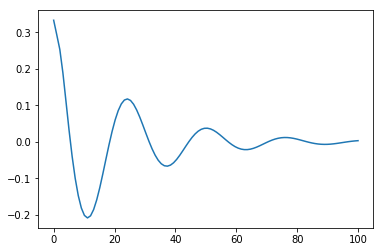

In [68]:
plt.plot(soln.t, real(soln.y[center_idx]))

In [111]:
modesoln = empty(numsteps, float) # population in mode of interest
totalsoln = empty(numsteps, float) # total population

norm = sum([abs(dot(evec,vecsoln[0]))**2 for evec in evecs.T])

for i in range(numsteps):
    # find overlap with mode of interest
    modesoln[i] = abs(dot(vecsoln[i], tmode.vector))**2/norm
    totalsoln[i] = sum([abs(dot(vecsoln[i], evec))**2 for evec in evecs.T])/norm
    
othersoln = totalsoln - modesoln # pop. in non-interesting modes
solnlist = [modesoln,totalsoln,othersoln]
ylabels = [moi.name, 'total', 'other']

In [112]:
abs(dot(vecsoln[0],tmode.vector))**2

0.7501655815179966

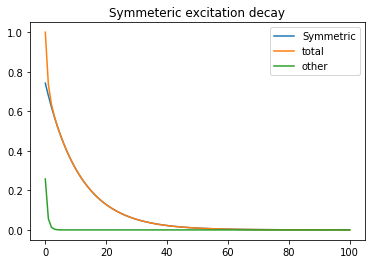

In [113]:
fig,ax = plt.subplots()

for s,l in zip(solnlist, ylabels):
    ax.plot(tsteps,s,label=l)
    
ax.set_title('Symmeteric excitation decay')
ax.legend()

In [117]:
# test write soln to csv
data = [tsteps] + [s for s in solnlist]
labels = ['t [gamma]'] + [l for l in ylabels]
num = int(sqrt(atomnum))
fname = f'soln_decay_{moi.name.lower()}_{num}x{num}_{gridname}.csv'
soln_to_csv(fname, data, labels)

In [118]:
# test retrieve soln from csv
data, labels = soln_from_csv(fname)
xsteps = data[0]
ydata = data[1:]

xlabel = labels[0]
ylabels = labels[1:]

In [119]:
labels

['t [gamma]', 'Symmetric', 'total', 'other']

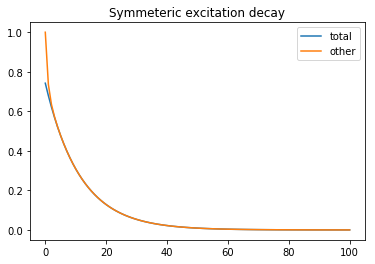

In [109]:
fig,ax = plt.subplots()

for s,l in zip(ydata, ylabels):
    ax.plot(xsteps,s,label=l)
    
ax.set_title('Symmeteric excitation decay')
ax.legend()